## Why waste Recognition?

The Objective of this project is to design a model that automatically detects the waste, segregates its category and send alerts to the concerned authorities to take action on it.

## Image Classification

In this project, we are training a convolutional neural network to classify an image as either cardboard, glass, metal, paper, plastic, or trash with the fastai library (built on PyTorch). We have collected related dataset from different sources to train the model

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

We have to zip the data we would like to use for training the model, and extracting below.

## 1. Data Extraction

In [5]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder will have six subfolders as we are right now maintaining six classes of waste

In [6]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [5]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

We are creating a bunch of destination folders like below

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>


## 2. Organizing images

After data extraction we are splitting the images in to three DataSets with a 50-25-25 split.

In [108]:
## paths will be train/cardboard, train/glass, etc...

subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

In [6]:
## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

## 3. Creating DataBunch for PyTorch

In [7]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Users/vyshnavi_chennareddy/Untitled Folder/data')

In [8]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

Here we are implementing multiprocessing of images by training sixteen images at a time

In [9]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\vyshnavi_chennareddy\Untitled Folder\data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\vyshnavi_chennareddy\Untitled Folder\data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: C:\Users\vyshnavi_chennareddy\Untitled Folder\data

In [10]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


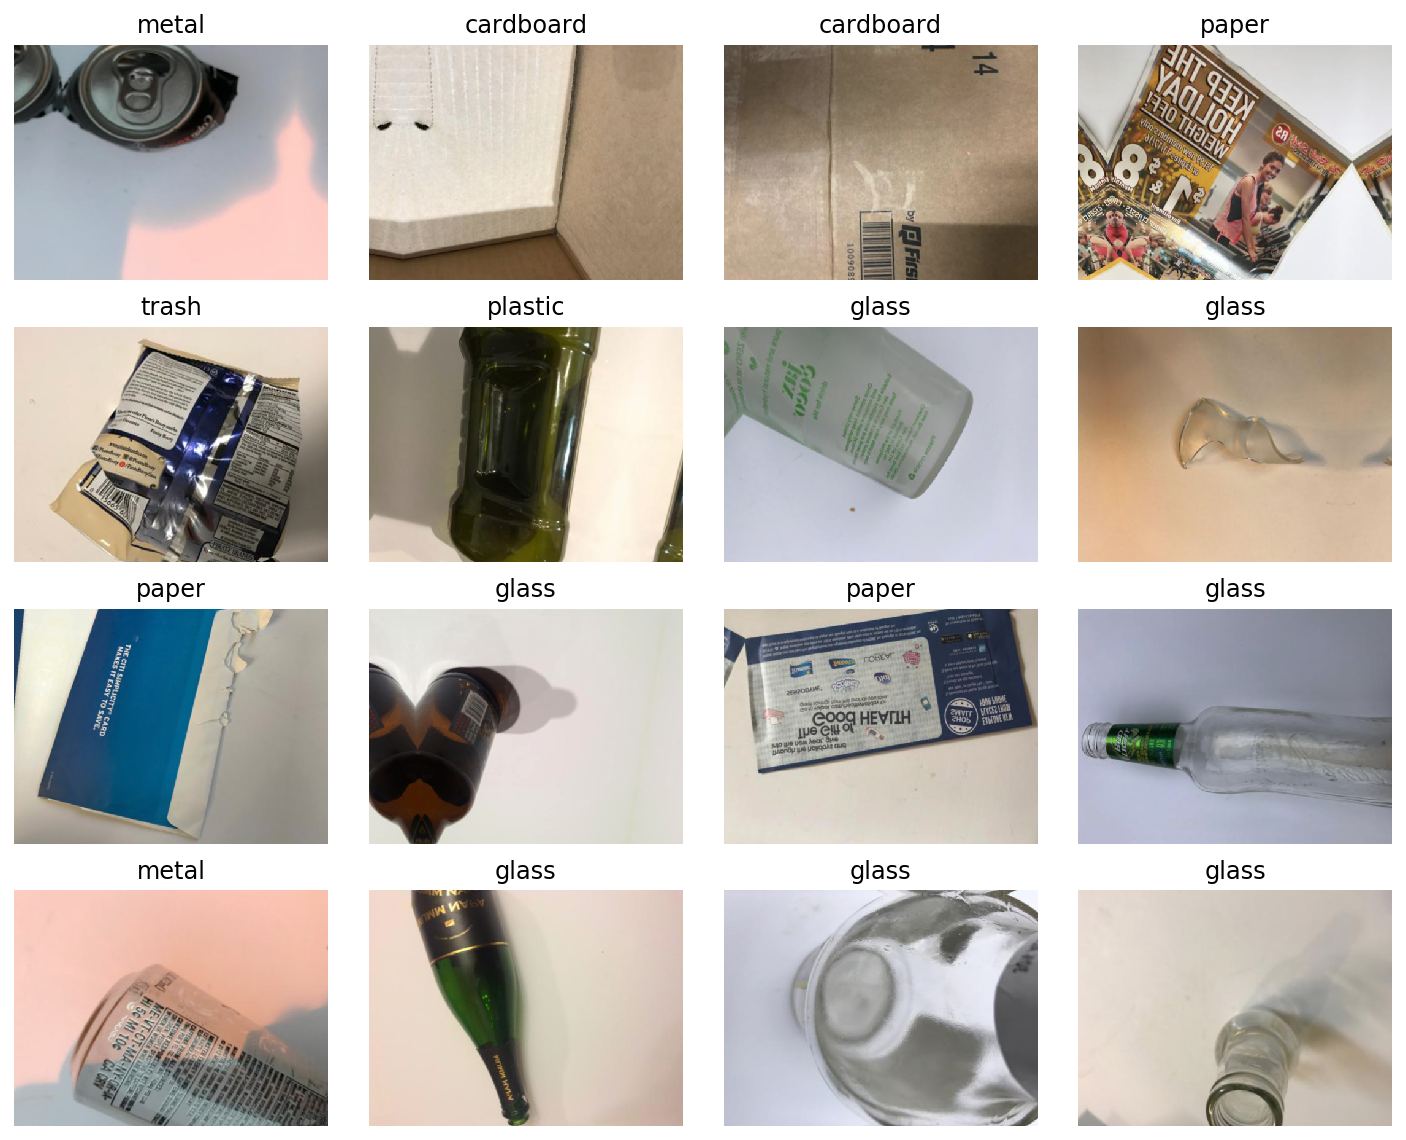

In [11]:
data.show_batch(rows=4,figsize=(10,8))

## 4. Model training

In [12]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

C:\Users\vyshnavi_chennareddy\AppData\Local\Continuum\anaconda3\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


### resnet34?

In particular, resnet34 is a CNN with 34 layers that's been pretrained on the [ImageNet database](http://www.image-net.org/). A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

In [ ]:
Once the model is trained we can skip pytorch basic training by loading the model directly as below

In [13]:
learn.load('smart-bin-learning-model')

Learner(data=ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\vyshnavi_chennareddy\Untitled Folder\data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\vyshnavi_chennareddy\Untitled Folder\data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: C:\Users\vyshnavi_chennareddy\Untitled Folder\data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Finding a learning rate

we are finding a learning rate for gradient descent to make sure that our neural network converges reasonably quickly without missing the optimal error.

### Training

In [15]:
learn.fit_one_cycle(5,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.571820,0.698976,0.231746,26:49
1,1.037642,0.585209,0.190476,25:18
2,0.900475,0.655853,0.193651,23:58
3,0.856717,0.655952,0.190476,24:24
4,0.865164,0.596206,0.190476,23:57
5,0.835599,0.671755,0.203175,24:28
6,0.756475,1.036682,0.290476,24:01
7,0.677996,0.612426,0.185714,25:35
8,0.665976,0.506045,0.141270,24:34
9,0.573110,0.523570,0.157143,24:39


KeyboardInterrupt: 

we ran this model for 13 epochs. What's cool about this fitting method is that the learning rate decreases with each epoch, allowing us to get closer and closer to the optimum.

In [ ]:
Saving the trained model for further usage without training

In [21]:
learn.save('smart-bin-learning-model')

### VIsualizing most incorrect images

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

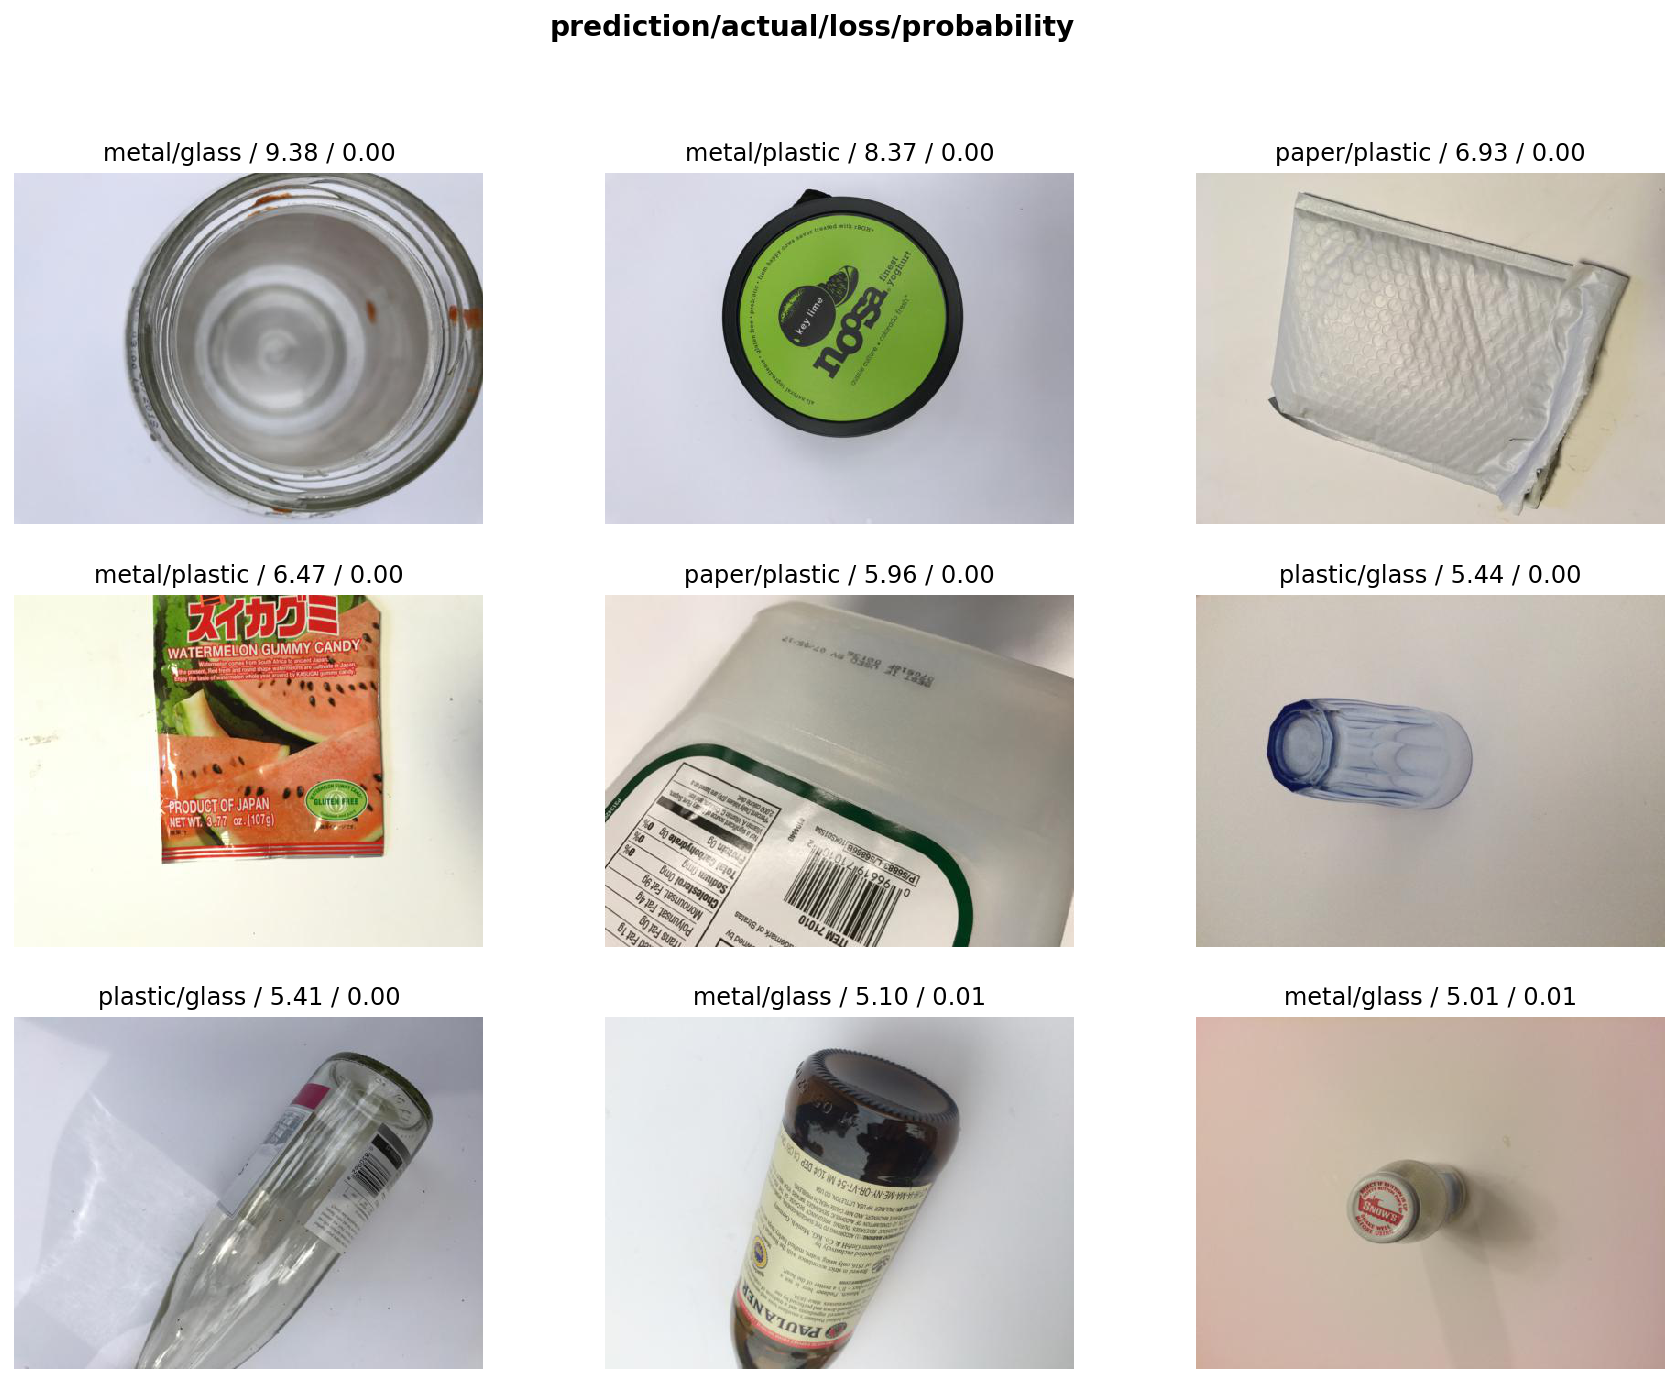

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

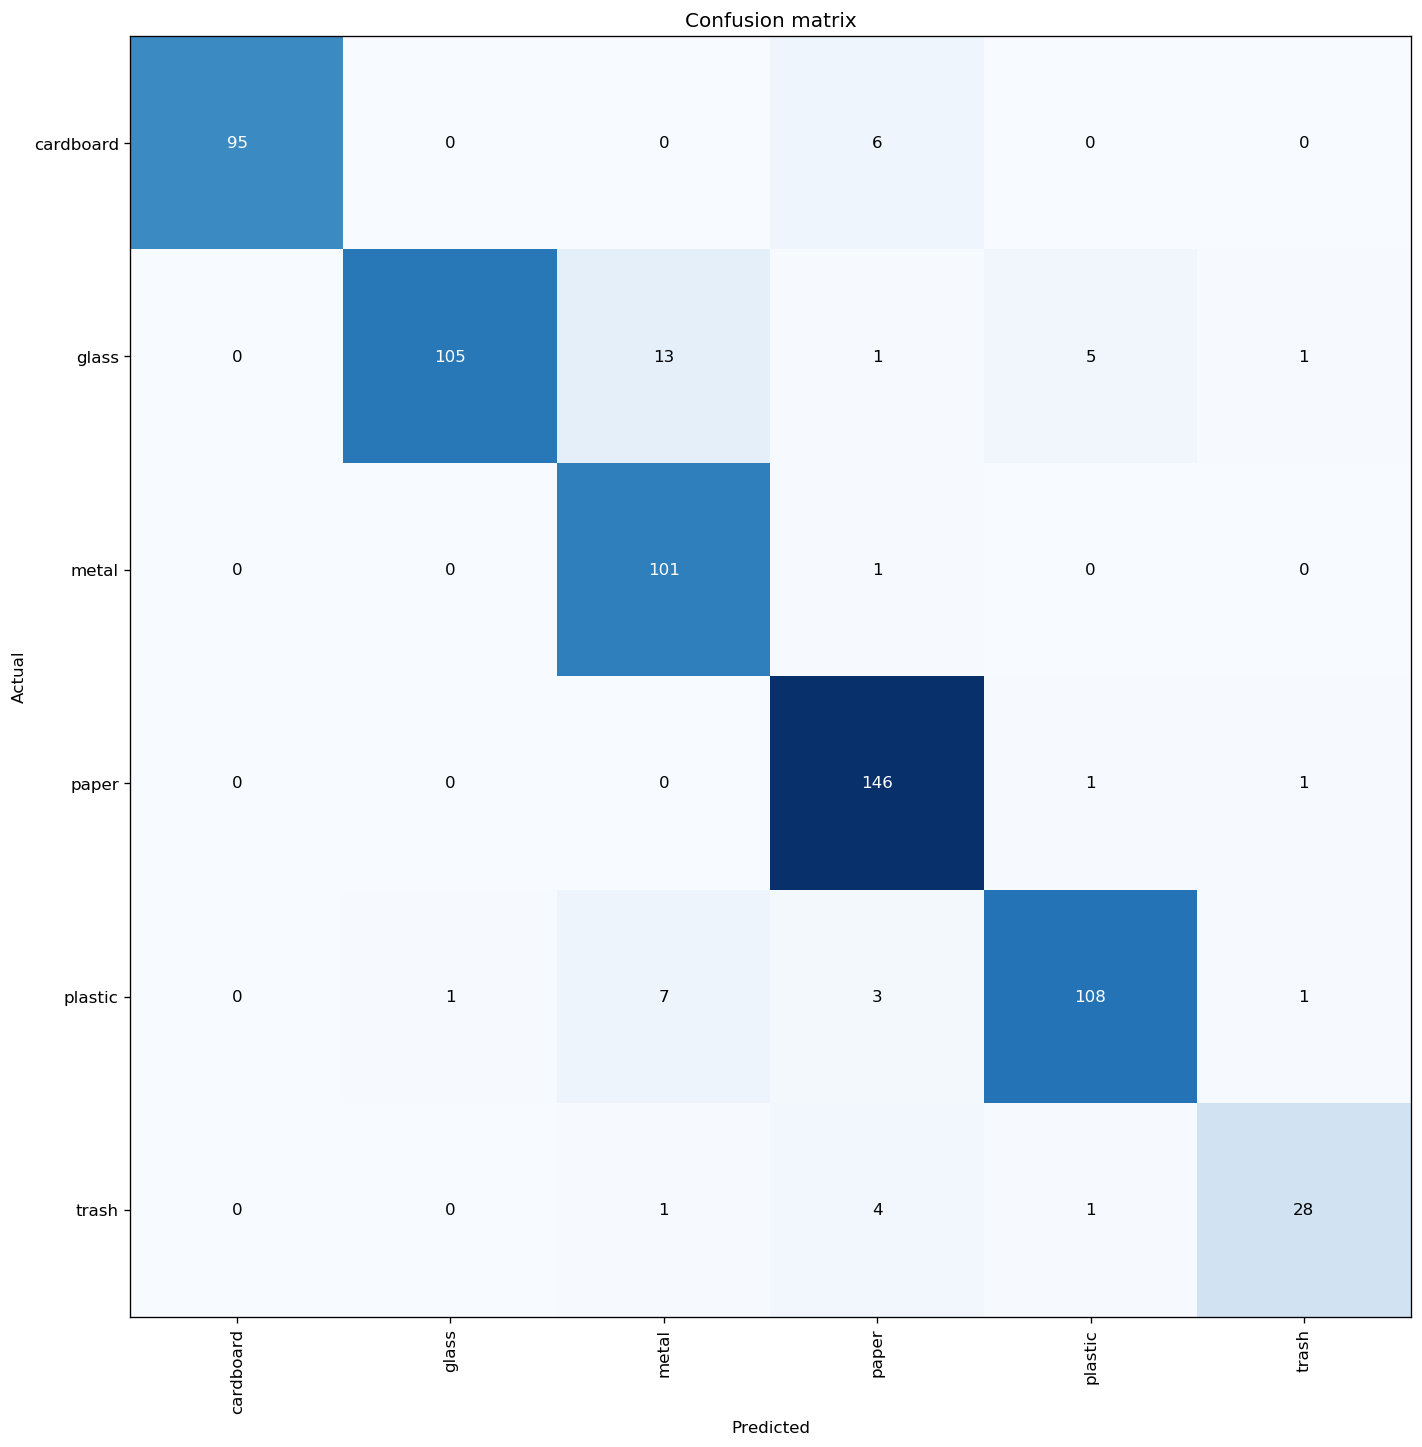

In [18]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

The list of most confused images is below.

In [19]:
interp.most_confused(min_val=2)

[('glass', 'metal', 13),
 ('plastic', 'metal', 7),
 ('cardboard', 'paper', 6),
 ('glass', 'plastic', 5),
 ('trash', 'paper', 4),
 ('plastic', 'paper', 3)]

## 4. Predictions based on test data

We are making predictions on the test data using the learner.get_preds() method. 

In [24]:
preds = learn.get_preds(ds_type=DatasetType.Test)

These are the predicted probablities for each image. This tensor has 365 rows -- one for each image -- and 6 columns -- one for each material category.

In [15]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9990e-01, 7.8376e-06, 6.5084e-08, 7.4685e-05, 1.6455e-08, 1.4459e-05],
        [9.9842e-01, 1.1880e-04, 2.8810e-05, 1.9760e-05, 1.2448e-05, 1.4017e-03],
        [9.9953e-01, 4.1382e-06, 1.4585e-07, 2.1966e-04, 2.2039e-05, 2.2632e-04],
        ...,
        [4.8132e-04, 5.1548e-04, 2.6387e-04, 1.3987e-01, 1.3113e-02, 8.4576e-01],
        [4.1562e-05, 6.0997e-07, 2.3580e-07, 9.8817e-01, 7.3249e-07, 1.1783e-02],
        [2.1532e-01, 2.9207e-03, 8.9031e-02, 1.3010e-01, 1.1906e-02, 5.5073e-01]])

In [18]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [20]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [21]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [67]:
#yhat

Verifying the predicted labels of all the images in random

In [62]:
learn.data.test_ds[0]

(Image (3, 384, 512), EmptyLabel )

In [37]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [ ]:
printing actual labels from the test dataset.

A quick check.

In [58]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])
print(y[615])

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'glass']
['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard']
trash


In [109]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 94   2   0   4   1   0]
 [  0 111  12   0   3   0]
 [  0   5  98   0   0   0]
 [  0   0   0 147   0   2]
 [  0   9   4   2 105   1]
 [  1   0   2   4   2  26]]


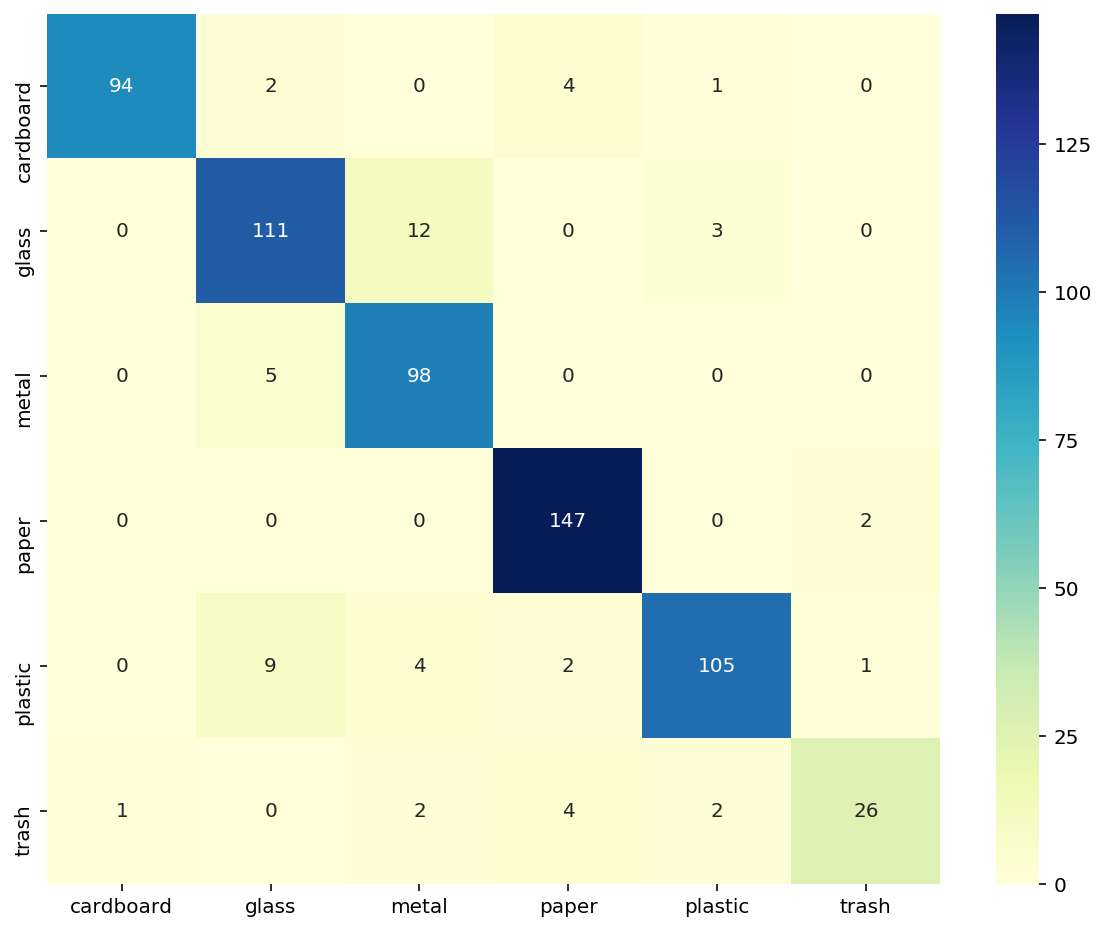

In [110]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [111]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [118]:
accuracy = correct/sum(sum(cm))
accuracy

0.9149606299212598

In [120]:
import processEAlerts as process
process.eAlerts(data, os, y, 615)

Alert sent
Image identified as trash
